# SNHT stat

Module for implementing statistical analysis based on metadata information

## Workflow

1. Extract the SNHT from saved .nc files (for testing and showing notebooks) as snht_prob

2. Extract metadata information as time series, convert into probability density *meta_prob* 

3. Use *meta_prob* ad prior to *snht_prob* to obtain posterior probability *snht_post* 



In [66]:
import h5py as h5
import json
import numpy as np
import matplotlib.pyplot as plt 
import os,sys

sys.path.append('modules')

 
# importing moduels for metadata handlng 
from sensor_functions import *
from plot_functions_sensor import *



#to re-merge and check sensors
l=['0-20500-0-93102', '0-20500-0-13713', '0-20500-0-23115', '0-20500-0-24255', '0-20500-0-13716', '0-20500-0-14792', '0-20500-0-12820', 
   '0-20500-0-93909', '0-20500-0-93117', '0-20500-0-14793', '0-20500-0-13773', '0-20500-0-93839']



In [68]:
# directory storing SNHT data
snht_dir = '/scratch/das/federico/SNHT_METADATA/'

# directory containing merged file information
merged = '/scratch/das/federico/MERGED_15JUNE2022'


## Preliminary: check metadata and SNHT 

- SNHT data obtained by the usual configuration in pyRAOBOCORE

- METADATA extracted by test_sensor_notebook.ipynb


cond is  True
cond combi is  False


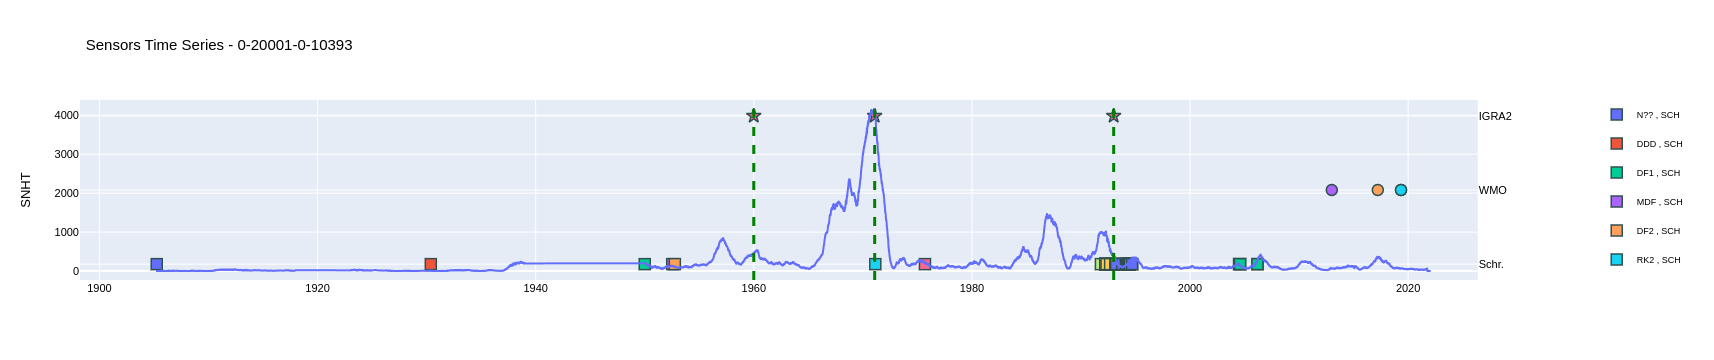

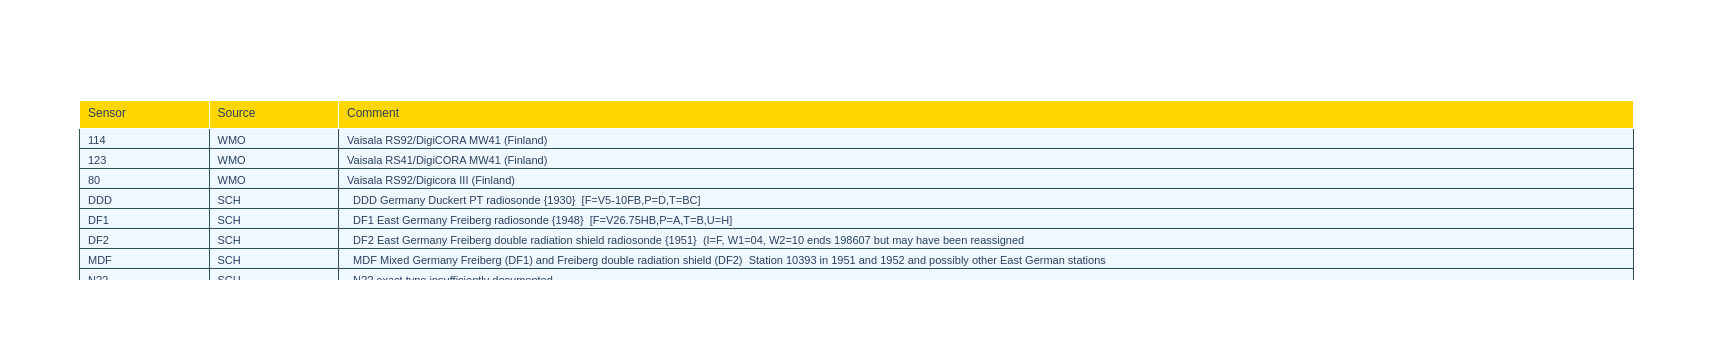

In [148]:
station = '0-20001-0-10393'


data_clean_all, all_sensor_station, data_all_wmo = get_data(merged, station, force_create=False)

# add a column where dates are expressed as fraction of years like in the SNHT file
data_clean_all['time_year_fraction'] = (pd.to_datetime(data_clean_all.date_time.values) - pd.to_datetime('1900-01-01') ).days /(365.25) + 1900 
meta_df = data_clean_all

# Initialize Plot Class
save_fig = False
plot = Plot(station.split('_')[-1], save=save_fig)
# making the plots
series = plot.time_series( data_clean_all, label='')
table = plot.sensor_table( all_sensor_station)
wmo_bar = plot.wmo_bar_plot(data_all_wmo)


series.show()

table.show()


In [77]:
data_clean_all.head(20)


,date_time,sensor_id,value,source,comment
0,1905-04-04 06:00:00,N??,1,SCH,N?? exact type insufficiently documented
1,1930-05-21 13:00:00,DDD,1,SCH,DDD Germany Duckert PT radiosonde {1930}^ <F...
2,1950-01-01 03:00:00,DF1,1,SCH,DF1 East Germany Freiberg radiosonde {1948}^...
3,1952-07-09 15:00:00,MDF,1,SCH,MDF Mixed Germany Freiberg (DF1) and Freiber...
4,1952-10-05 03:00:00,DF2,1,SCH,DF2 East Germany Freiberg double radiation s...
5,1971-02-22 00:00:00,RK2,1,SCH,"RK2 USSR RKZ-2 radiosonde {1967}^ (W2=20, T=..."
6,1975-09-12 00:00:00,XXX,1,SCH,XXX Reject all obs with this station ID in t...
7,1991-10-31 23:00:00,RR2,1,SCH,RR2 USSR MARS-2 unspecified model {1983}^ (T...
8,1992-03-25 11:00:00,RRn,1,SCH,RRn USSR MARS-2-2 radiosonde no correction 3...
9,1992-03-25 23:00:00,RR2,1,SCH,RR2 USSR MARS-2 unspecified model {1983}^ (T...


In [108]:
f = data_clean_all[data_clean_all.source == 'IGRA2']


In [119]:
f

,date_time,sensor_id,value,source,comment,time_year_fraction
72,1960-01-01 00:00:00,IGRA2,3,IGRA2,"USING SONDE MODEL , I1 , E GERMANY FREIBERG UN...",1959.997262
73,1971-02-01 00:00:00,IGRA2,3,IGRA2,"CHANGE SONDE MODEL , E GERMANY FREIBERG UNSPEC...",1971.082820
74,1993-01-01 00:00:00,IGRA2,3,IGRA2,"USING SONDE MODEL , I1 , VAISALA RS80 UNSPECIF...",1992.999316


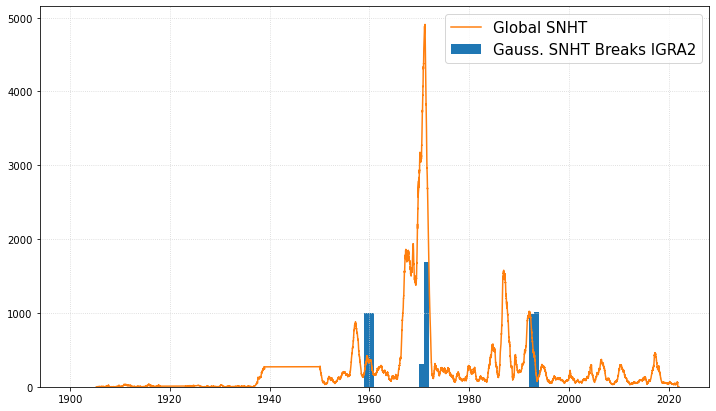

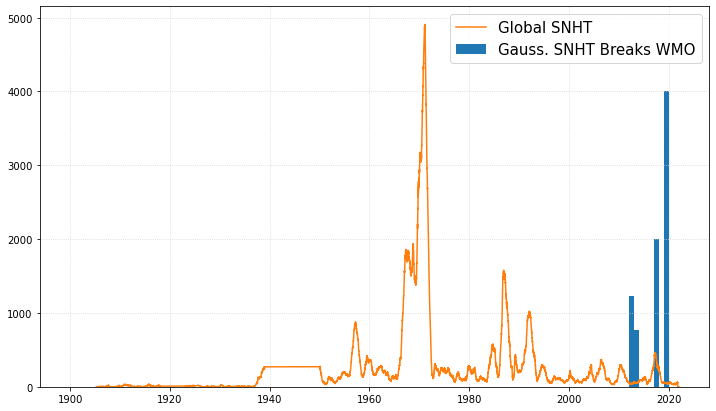

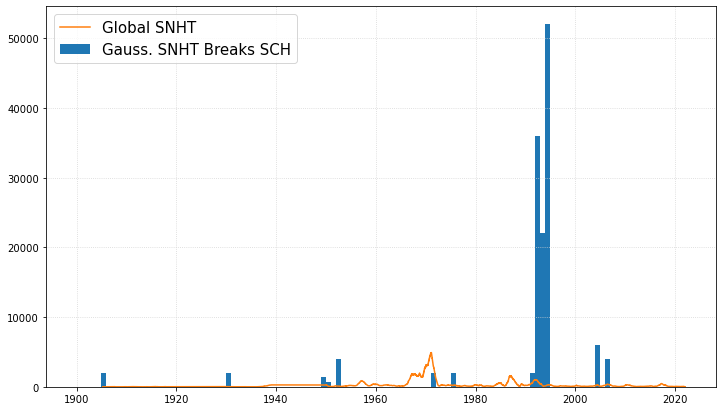

In [126]:
# Gaussianize IGRA2 breaks

# reflects uncertainties around the metadata dates (expressed in days) )

windows = {'IGRA2': 30 , 'WMO':1, 'SCH' : 1 }

for source in ['IGRA2' , 'WMO', "SCH"]:
    
    meta = data_clean_all
    js = json_dict
    meta = meta.loc[meta.source == source]


    all_x , all_y = [],[]

    fs = 15
    days = np.array( js['days_since_1900'] ) / (365.25) + 1900 
    snht = js['tsasum']
    breaks_x = np.take( days, np.array(js['breaks']) ) 
    breaks_y = np.take(np.array(snht) , js['breaks']  )

    window = windows[source]/365

    # Gaussianize SNHT breaks
    for b in meta['time_year_fraction'].values:

        # s = SNHT value i.e. Gaussian scale factor 
        sample = 1 # scale factor if needed 
        s = 2000 # peak of the metadata
        gauss_sample = np.random.normal(b, window, int(sample*s) )

        all_x.extend(gauss_sample)



    bins = 50
    fig_fit = plt.figure(figsize = (12,7) )

    lab_gauss_snht = source

    plt.hist(all_x, bins = range(1900, 2022, 1), label = 'Gauss. SNHT Breaks ' + lab_gauss_snht )
    plt.plot( days ,  snht , label = 'Global SNHT')

    plt.legend(fontsize = fs)
    plt.grid(ls = ':' , color = 'lightgray')    
    plt.show()
    plt.close()

In [74]:
# Select station

#lin = '10393'
#stat = lin 

break_file = snht_dir + '/' + '0-20001-0-10393_breakanalysis.json'
f = open(break_file)
json_dict =json.load(f)

print('--- Keys in json file: ', json_dict.keys() )

--- Keys in json file:  dict_keys(['days_since_1900', 'tsasum', 'breaks'])


In [75]:
from numpy.polynomial import Polynomial
from scipy.interpolate import interp1d

def plot_snht_json(js, stat):
    """ Rapid checker of SNHT data """ 
    
    fs = 15
    
    days = np.array( js['days_since_1900'] ) / (365.25) + 1900 
    snht = js['tsasum']
    breaks_x = np.take( days, np.array(js['breaks']) ) 
    breaks_y = np.take(np.array(snht) , js['breaks']  )
    
    fig_snht = plt.figure(figsize = (12,7) )
    
    plt.plot( days ,  snht , label = 'Global SNHT')
    plt.title('RAOBCORE SNHT for ' + stat, y  = 1.03 , fontsize = fs )
    
    plt.scatter(breaks_x , breaks_y , label = 'Breaks' , color = 'lime')
    plt.grid(ls = ':' , color = 'lightgray')

    
    cubic = interp1d(days, snht, kind='cubic')
    all_dates = np.linspace(min(days), max(days), 5000)
    data = cubic(all_dates) 
    plt.plot( all_dates ,  data , label = 'Cubic Spline SNHT')

    plt.legend( fontsize = fs)
    #print(all_dates, data)
    
    
    

    
    return fig_snht

[1905.25393566 1905.27729365 1905.30065164 ... 2021.9738179  2021.99717589
 2022.02053388] [ 0.00000000e+00  1.11774440e-65 -7.08556592e-62 ...  7.70763570e-39
 -4.84171475e-43  0.00000000e+00]


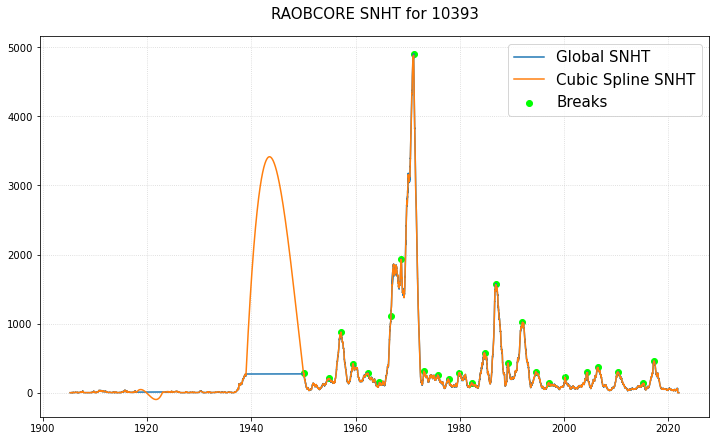

In [31]:
fig_snht = plot_snht_json(json_dict, stat)

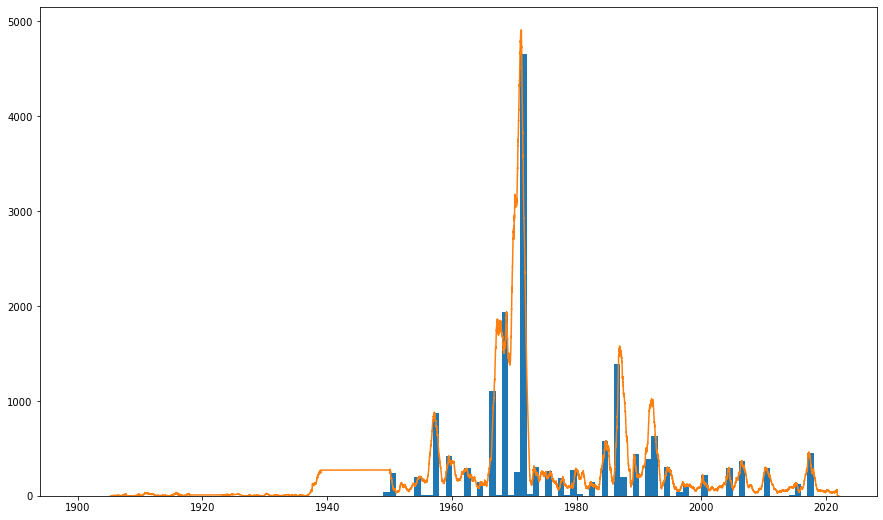

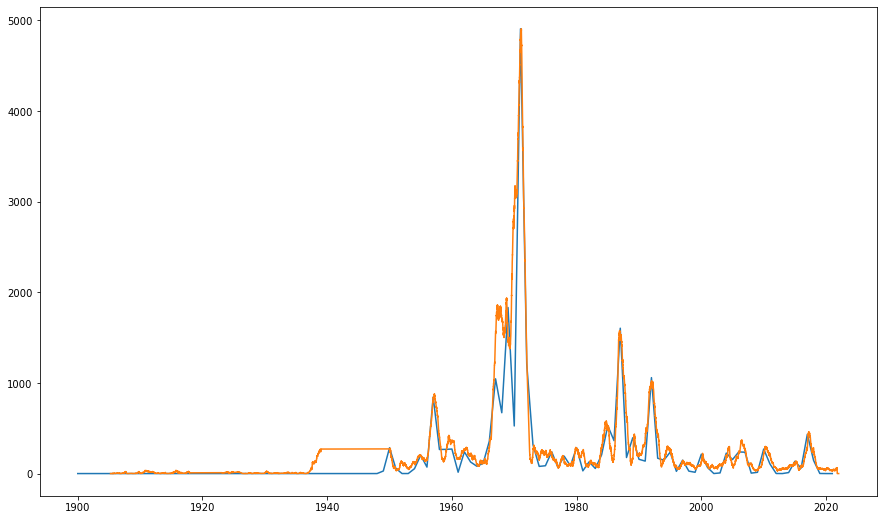

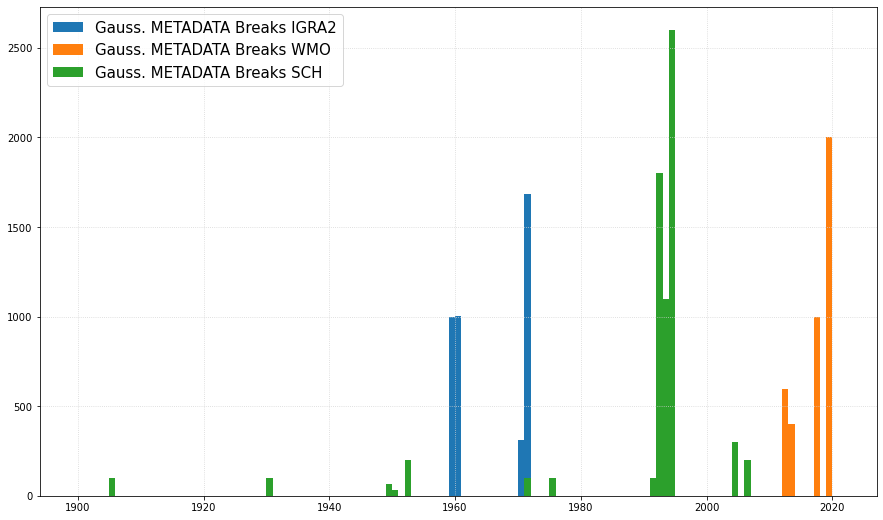

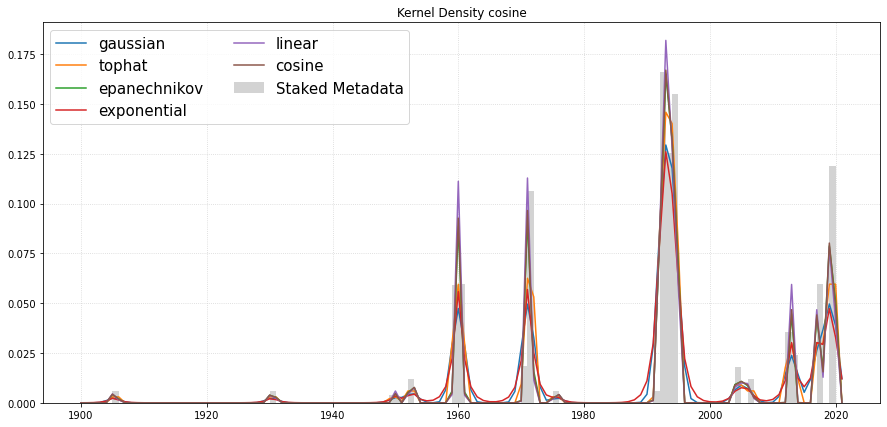

0

In [190]:
from numpy import hstack
from sklearn.neighbors import KernelDensity
from numpy import asarray, exp



def get_kernel_density(data, kernel='cosine', bw=1):
    """ Extract a Kernel density using Keras """
    model = KernelDensity(bandwidth= bw, kernel=kernel)
    data = np.array(data).reshape((len(data), 1))
    model.fit(data)

    # sample probabilities for a range of outcomes
    values = asarray([value for value in range(1900, 2022, 1)])
    values = values.reshape((len(values), 1))
    prob = model.score_samples(values)
    prob = exp(prob)
    # plot the histogram and pdf

    return values, prob
        
        
    
    
def make_Gauss_breaks(js , meta_df):
    """ Creates a Gaussian distribution around each break point, with a certain std of specified days.
        input:
                js::      json file created by the pyRAOBCORE.py script with break points 
                meta::    pandas df containign metadata information, created by 
                
        window: must be expressed as fraction of years (1 day = 1/365 ) """
    
    snht_hist_x=[]
    
    fs = 15
    days = np.array( js['days_since_1900'] ) / (365.25) + 1900 
    snht = js['tsasum']
    breaks_x = np.take( days, np.array(js['breaks']) ) 
    breaks_y = np.take(np.array(snht) , js['breaks']  )


    
    ############################################## Gaussianize SNHT breaks
    window = 30/365
    for b,s in zip(breaks_x, breaks_y):
     
        # s = SNHT value i.e. Gaussian scale factor 
        sample = 1 # scale factor if needed 
        gauss_sample = np.random.normal(b, window, int(sample*s) )
        snht_hist_x.extend(gauss_sample)

    bins = range(1900, 2022, 1)
    fig = plt.figure(figsize = (15,9) )
    
    plt.hist(snht_hist_x, bins = bins, label = 'Gauss. SNHT Breaks ' )
    plt.plot( days ,  snht , label = 'Global SNHT')
    plt.show()
    plt.close()
    
    
    ############################################## Density estimate of the SNHT
    values, probabilities = get_kernel_density(snht_hist_x , bw=0.5, kernel='gaussian')
    fig = plt.figure(figsize = (15,9) )
    f = max(snht) / max(probabilities)  # rescale since it is a probability 

    
    plt.plot(values[:], probabilities * f , label = 'SNHT kernel ' + 'cosine' , lw = 1.5)
    plt.plot( days ,  snht , label = 'Global SNHT')

    plt.show()
    plt.close()
    
    
    
    fig = plt.figure(figsize = (15,9) )

    # Gaussianize METADATA breaks
    windows = {'IGRA2': 30 , 'WMO':1, 'SCH' : 1 }
    peaks = {'IGRA2': 2000 , 'WMO':1000, 'SCH' : 100 }
    
    all_stacks = []
    
    for source in ['IGRA2' , 'WMO', "SCH"]:
    #for source in ['IGRA2']:

        meta = meta_df.loc[meta_df.source == source]
        all_x = []

        window = windows[source]/365

        # Gaussianize SNHT breaks
        for b in meta['time_year_fraction'].values:
            # s = SNHT value i.e. Gaussian scale factor 
            sample = 1 # scale factor if needed 
            #s = 2000 # peak of the metadata
            p = peaks[source]
            
            gauss_sample = np.random.normal(b, window, int(sample*p) )
            all_stacks.extend(gauss_sample)
            all_x.extend(gauss_sample)
            
        #print(all_x)
        
        plt.hist(all_x, bins =bins, label = 'Gauss. METADATA Breaks ' + source )    
    


    plt.legend(fontsize = fs)
    plt.grid(ls = ':' , color = 'lightgray')
    plt.show()
    plt.close()
    
    
    # Try to fit a probability density using Keras KernelDensity
    stacked = hstack(all_stacks)
    
    kernels = plt.figure(figsize = (15,7) )
    plt.hist(stacked, bins=bins, density=True, color = 'lightgray', label= 'Staked Metadata')
    
    for kernel in ["gaussian", "tophat", "epanechnikov", "exponential", "linear", "cosine"]:
        
        values, probabilities = get_kernel_density(stacked, kernel=kernel)
        # plot the histogram and pdf
        
        plt.title("Kernel Density " + kernel )
        plt.plot(values[:], probabilities, label = kernel , lw = 1.5)
 
    plt.grid(ls = ':' , color = 'lightgray')
    plt.legend(fontsize = fs, ncol = 2)
    plt.show()

    return 0


make_Gauss_breaks(json_dict , meta_df)


In [34]:
fig_snht.show()

### IDEA 1
Assume at each break point we have a probability of break point which is modelled a normal distribution with a certain width (e.g. plus/minus 15 days)
and a certain height, which is proportional to the NSHT.

Note that,
$N(\sigma, \mu)(\mu) \sim \frac{0.4}{\sigma}$
i.e. the height depends on the $\sigma$ value, so we need to rescale by the value of the SNHT stat.


In [ ]:
from numpy.random import normal

### IDEA 2
Get each break point, assume a fixed window of uncertainy (e.g. 5 days if peak is very strong, 30 days if unclear)
and fit a plynomial function where maximu is at the break.


In [ ]:
b = 

In [ ]:
# SNHT files analysis (what's inside)

# feedbackglobbgmon010393.nc
# feedbackglobbincorrmon010393.nc
# feedbackglobbincorrsave010393.nc
# feedbackglobbincorrsave_rio24_010393.nc
# feedbackglobbincorrsave_rit24_010393.nc
 
    
f = snht_dir + '/' + 'feedbackglobbgmon010393.nc'
ff = h5.File(f, 'r')

In [ ]:
ff.keys()

In [ ]:
ff['datum'][:]

In [ ]:
ff['press'][:]

In [ ]:
# station



In [ ]:
# Extract metadata time series

